In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize
from tabulate import tabulate
from helper_functions import helperFunctions, params

In [2]:
hf = helperFunctions("datafile.csv")

In [3]:
df = hf.import_datafile("datafile.csv")

In [4]:
df.head()

,S0,k,n,m,E*,m6,E,S
0,20,80,0.4,0.01,0.01,0.0,0.0025,26.900
1,20,80,0.4,0.01,0.01,0.0,0.0050,29.074
2,20,80,0.4,0.01,0.01,0.0,0.0075,30.602
3,20,80,0.4,0.01,0.01,0.0,0.0100,31.842
4,20,80,0.4,0.01,0.01,0.0,0.0125,32.906


In [5]:
df.describe()

,S0,k,n,m,E*,m6,E,S
count,725040.000000,725040.000000,725040.000000,725040.000000,725040.000000,725040.000000,725040.000000,725040.000000
mean,98.460775,111.284343,0.368305,0.075175,0.206859,-0.513009,0.301251,151.353386
std,108.107216,72.784134,0.232147,0.070100,0.212311,0.679213,0.173204,125.281579
min,5.000000,50.000000,0.050000,0.001000,0.010000,-2.000000,0.002500,7.053600
25%,20.000000,80.000000,0.100000,0.010000,0.010000,-0.600000,0.151875,52.299000
50%,25.000000,90.000000,0.400000,0.050000,0.100000,-0.300000,0.302500,88.174000
75%,200.000000,100.000000,0.500000,0.090000,0.500000,0.000000,0.452500,243.860000
max,300.000000,300.000000,0.800000,0.200000,0.500000,0.000000,0.602500,585.160000


In [6]:
def optimise_law(df_curve, p = True):
    
    error_at_each_step = []
    def callback_func(params):
        error = hf.viscoplastic_law_error(params, epsilon, epsilon_dot, sigma_exp)
        error_at_each_step.append(error)
    
    # Initialize parameters
    params_init = np.array([50, 0.4, 0.001, -2, 5])  # Initial guess for k, n, m, m6, sigma0

    epsilon = df_curve["E"].values
    epsilon_dot = df_curve["E*"].values
    sigma_exp = df_curve["S"].values

    # Perform gradient descent using SciPy's minimize function
    result = minimize(hf.viscoplastic_law_error, params_init, args=(epsilon, epsilon_dot, sigma_exp), method='L-BFGS-B', callback=callback_func)

    # Extract optimal parameters
    optimal_params = result.x
    k_opt, n_opt, m_opt, m6_opt, sigma0_opt = optimal_params
    



    if p == True:
        # plt.plot(error_at_each_step)
        
        k = df_curve.iloc[0]["k"]
        n = df_curve.iloc[0]["n"]
        m = df_curve.iloc[0]["m"]
        m6 = df_curve.iloc[0]["m6"]
        sigma0 = df_curve.iloc[0]["S0"]
        
        # Round the optimal parameters to 2 decimal places
        k_opt_rounded = round(k_opt, 2)
        n_opt_rounded = round(n_opt, 2)
        m_opt_rounded = round(m_opt, 2)
        m6_opt_rounded = round(m6_opt, 2)
        sigma0_opt_rounded = round(sigma0_opt, 2)
        error = hf.viscoplastic_law_error((k, n, m, m6, sigma0), epsilon, epsilon_dot, sigma_exp)
        error_opt_rounded = round(error_at_each_step[-1], 5)
        

        
        # Define data as a list of tuples
        data = [
            ("Final Error", error_opt_rounded, error),
            ("k", k_opt_rounded, k),
            ("n", n_opt_rounded, n),
            ("m", m_opt_rounded, m),
            ("m6", m6_opt_rounded, m6),
            ("sigma0", sigma0_opt_rounded, sigma0)
        ]

        # Print as a table
        table = tabulate(data, headers=["Parameter", "Optimal Value", "Real Value"], tablefmt="grid")
        print(table)

    optimal_params = params(sigma0_opt, k_opt, n_opt, m_opt, m6_opt)
    return optimal_params


In [7]:
def validate_from_index(df, curve_index):
    df_curve = df[240*curve_index: 240*(curve_index+1)]

    opt_params = optimise_law(df_curve)
    real_params = params(df_curve["S0"].values[0], df_curve["k"].values[0], df_curve["n"].values[0], df_curve["m"].values[0], df_curve["m6"].values[0])
    stress = df_curve["S"].values
    hf.validate(df_curve["E*"].values[0], real_params, opt_params, stress)

+-------------+-----------------+--------------+
| Parameter   |   Optimal Value |   Real Value |
+=============+=================+==============+
| Final Error |           1e-05 |       0.8477 |
+-------------+-----------------+--------------+
| k           |          50     |     200      |
+-------------+-----------------+--------------+
| n           |           0.8   |       0.8    |
+-------------+-----------------+--------------+
| m           |          -0.1   |       0.2    |
+-------------+-----------------+--------------+
| m6          |           0.03  |       0      |
+-------------+-----------------+--------------+
| sigma0      |          25.19  |      25      |
+-------------+-----------------+--------------+


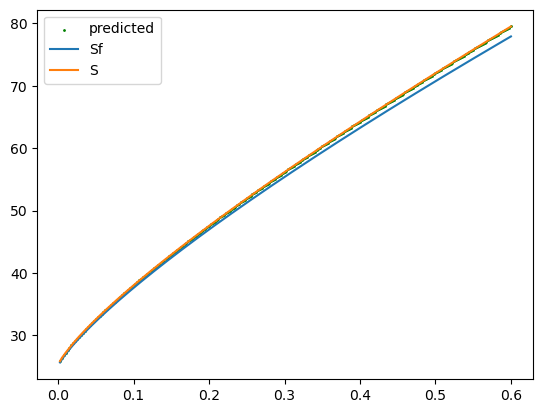

In [16]:
validate_from_index(df, 73)

In [11]:
def compute_curves(df):
    total_iterations = len(df) // 240
    results = []
    for i in range(total_iterations):
        df_curve = df[240 * i: 240 * (i+1)]
        opt_params = optimise_law(df_curve, p = False)
        
        row1 = df_curve.iloc[0]       
        error_opt = hf.viscoplastic_law_error((opt_params.k, opt_params.n, opt_params.m, opt_params.m6, opt_params.s0), df_curve["E"].values, df_curve["E*"].values, df_curve["S"].values)
        error = hf.viscoplastic_law_error((row1["k"], row1["n"], row1["m"], row1["m6"], row1["S0"]), df_curve["E"].values, df_curve["E*"].values, df_curve["S"].values)
        

        results.append({
            'k_opt': opt_params.k,
            'n_opt': opt_params.n,
            'm_opt': opt_params.m,
            'm6_opt': opt_params.m6,
            'error_opt': error_opt,
            'k_real': row1["k"],
            'n_real': row1["n"],
            'm_real': row1["m"],
            'm6_real': row1["m6"],
            'error': error
        })
        
        # Print progress
        progress_percent = (i + 1) / total_iterations * 100
        print(f"Processed {i + 1}/{total_iterations} ({progress_percent:.2f}%)", end="\r")


    return pd.DataFrame(results)

In [12]:
results = compute_curves(df)

C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:31: RuntimeWarning: overflow encountered in power
  sigma_pred = sigma0 + k * epsilon**n * epsilon_dot**m * np.exp(m6*epsilon)
C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:31: RuntimeWarning: invalid value encountered in multiply
  sigma_pred = sigma0 + k * epsilon**n * epsilon_dot**m * np.exp(m6*epsilon)
C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:31: RuntimeWarning: overflow encountered in exp
  sigma_pred = sigma0 + k * epsilon**n * epsilon_dot**m * np.exp(m6*epsilon)


C:\Users\dunzu\anaconda3\Lib\site-packages\scipy\optimize\_numdiff.py:576: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:31: RuntimeWarning: overflow encountered in multiply
  sigma_pred = sigma0 + k * epsilon**n * epsilon_dot**m * np.exp(m6*epsilon)


C:\Users\dunzu\Documents\Project\ML-for-Material-Behaviour\helper_functions.py:47: RuntimeWarning: overflow encountered in square
  return np.mean((np.array(sigma_pred) - np.array(sigma_exp))**2)


In [13]:
results.to_csv("parameterPredictions.csv")

In [14]:
results.head()

,k_opt,n_opt,m_opt,m6_opt,error_opt,k_real,n_real,m_real,m6_real,error
0,49.995643,0.388544,-0.095083,0.027495,0.001093,80.0,0.4,0.01,0.0,0.775755
1,49.995788,0.404332,-0.055768,0.008505,0.002611,80.0,0.4,0.05,0.0,0.619323
2,49.995508,0.407530,-0.016007,0.005692,0.002225,80.0,0.4,0.09,0.0,0.496602
3,49.997893,0.493722,-0.093989,0.025984,0.000688,80.0,0.5,0.01,0.0,0.739268
4,49.997712,0.506709,-0.055916,0.008208,0.001965,80.0,0.5,0.05,0.0,0.588397


In [15]:
results["error_opt"].argmin()

73

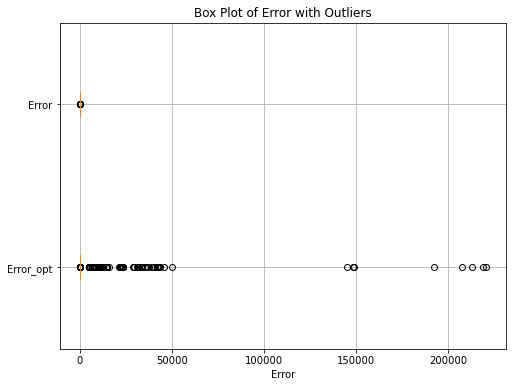

In [35]:
plt.figure(figsize=(8, 6))
positions = [1,2]
plt.boxplot([results['error_opt'], results['error']], positions=positions, vert=False, patch_artist=True, showfliers=True)
box_labels = ['Error_opt', 'Error']

plt.title('Box Plot of Error with Outliers')
plt.xlabel('Error')
plt.yticks(positions, box_labels)
plt.grid(True)
plt.show()

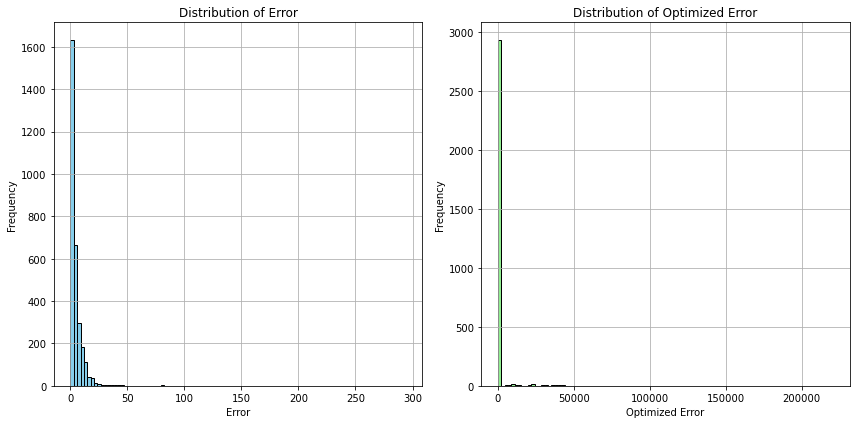

In [36]:
# Assuming results is your DataFrame containing both 'error' and 'error_opt' columns

plt.figure(figsize=(12, 6))

# Plot for 'error' column
plt.subplot(1, 2, 1)
plt.hist(results['error'], bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Error')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)

# Plot for 'error_opt' column
plt.subplot(1, 2, 2)
plt.hist(results['error_opt'], bins=100, color='lightgreen', edgecolor='black')
plt.title('Distribution of Optimized Error')
plt.xlabel('Optimized Error')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.show()


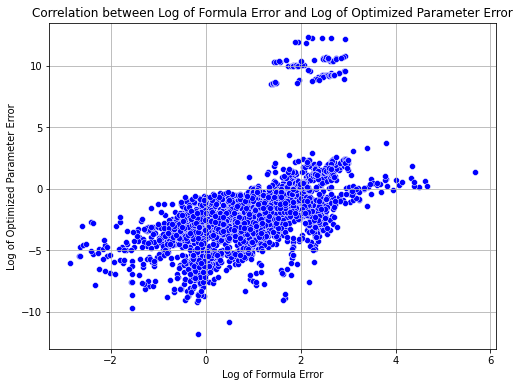

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming results is your DataFrame containing both 'error' and 'error_opt' columns

plt.figure(figsize=(8, 6))

# Compute the logarithm of the errors
results['log_error'] = np.log(results['error'])
results['log_error_opt'] = np.log(results['error_opt'])

# Create scatter plot of logarithms of errors
sns.scatterplot(x='log_error', y='log_error_opt', data=results, color='blue')

# Set title and labels
plt.title('Correlation between Log of Formula Error and Log of Optimized Parameter Error')
plt.xlabel('Log of Formula Error')
plt.ylabel('Log of Optimized Parameter Error')
plt.grid(True)

plt.show()


In [62]:
np.argmax(results["error_opt"])

2524

+-------------+-----------------+--------------+
| Parameter   |   Optimal Value |   Real Value |
+=============+=================+==============+
| Final Error |       220481    |      8.69264 |
+-------------+-----------------+--------------+
| k           |           50.01 |    300       |
+-------------+-----------------+--------------+
| n           |           -0.48 |      0.1     |
+-------------+-----------------+--------------+
| m           |           -0.43 |      0.001   |
+-------------+-----------------+--------------+
| m6          |           -1.81 |      0       |
+-------------+-----------------+--------------+
| sigma0      |            5.04 |    300       |
+-------------+-----------------+--------------+


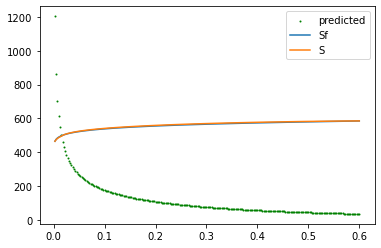

In [70]:
validate_from_index(df, 2524)

In [63]:
results.head(30)

,k_opt,n_opt,m_opt,m6_opt,error_opt,k_real,n_real,m_real,m6_real,error,log_error,log_error_opt
0,49.995712,0.388544,-0.095083,0.027495,0.001093,80.0,0.4,0.010,0.0,0.775755,-0.253918,-6.818986
1,49.995755,0.404331,-0.055768,0.008506,0.002611,80.0,0.4,0.050,0.0,0.619323,-0.479129,-5.947957
2,49.995508,0.407530,-0.016007,0.005692,0.002225,80.0,0.4,0.090,0.0,0.496602,-0.699966,-6.107947
3,49.997912,0.493721,-0.093989,0.025986,0.000688,80.0,0.5,0.010,0.0,0.739268,-0.302095,-7.281409
4,49.997738,0.506708,-0.055915,0.008211,0.001965,80.0,0.5,0.050,0.0,0.588397,-0.530353,-6.232211
5,49.997176,0.498403,-0.014798,0.021557,0.000596,80.0,0.5,0.090,0.0,0.469226,-0.756671,-7.425152
6,49.998739,0.592283,-0.092944,0.032032,0.000166,80.0,0.6,0.010,0.0,0.696391,-0.361844,-8.702544
7,49.998234,0.602984,-0.055214,0.016132,0.000777,80.0,0.6,0.050,0.0,0.552937,-0.592512,-7.159517
8,49.997704,0.582701,-0.011263,0.048905,0.000151,80.0,0.6,0.090,0.0,0.441997,-0.816451,-8.797938
9,50.000530,0.251400,-0.120960,0.207023,0.153576,90.0,0.4,0.010,0.0,0.926846,-0.075968,-1.873559
